## Analysis
In this analysis, a resnet18 model is used to train over chest xray images to predict covid-19
The normal images are sampled from the kaggle chest xray images. 
In current experiment we only use chest xray to check if covid-19 is present 
Follow up would try to incorporate the effect of the age/gender.

In [41]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--dataset_name', type=str, default='COVID19_ChestXray') # required
parser.add_argument('--model_name', type=str, default='resnet18') #required
parser.add_argument('--result_path', type=str, default='result', help='output path')
parser.add_argument('--data_path', type=str, default='dataset_partition', help='path for data partition')

# Training
parser.add_argument('--num_epochs', type=int, default=30)
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--lr', type=float, default=1e-4)
parser.add_argument('-e', '--lr_decay', type=float, default=0.995,
                    help='Learning rate decay, applied every step of the optimization')
parser.add_argument('--seed', type=int, default=1,
                    help='Random seed to use')
parser.add_argument('--log_step', type=int, default=100, help='step size for prining log info')
parser.add_argument('--save_step', type=int, default=20, help='step size for saving trained models')

parser.add_argument('--flag_retrain', default=False, action='store_true', help='Re train')
parser.add_argument('--flag_reg', default=False, action='store_true', help='Regularizer')
parser.add_argument('--flag_plot', default=False, action='store_true', help='Plot')
parser.add_argument('--img_size', type=int, default=256)

# Model parameters
args = parser.parse_args("")

In [42]:
import os, sys, time, shutil
import numpy as np
import importlib
import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils
import torchvision
import pdb

device=torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# Arguments
model_name=args.model_name + '-' + args.dataset_name
dataset_path=os.path.join(args.data_path, args.dataset_name)
output_path=os.path.join(args.result_path, model_name)

# saved checkpoint
model_path=os.path.join(output_path, 'snapshots')
net_path=os.path.join(model_path, 'net.pth')
adv_path = os.path.join(model_path, 'adv.pth')
sample_path=os.path.join(output_path, 'samples')
log_path=os.path.join(output_path, "log.txt")
run_path = os.path.join(output_path, 'runs')

params_str = 'debug'
writer_path=os.path.join(run_path, params_str) 

# makedir
def make_dir(dirname, rm=False):
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    elif rm:
        print('rm and mkdir ', dirname)
        shutil.rmtree(dirname)
        os.makedirs(dirname)

make_dir(args.result_path)
make_dir(output_path)
make_dir(model_path)
make_dir(sample_path)
make_dir(run_path)
logf=open(log_path, 'w')
make_dir(writer_path, rm=True)
writer=SummaryWriter(comment=model_name, log_dir=writer_path)

rm and mkdir  result/resnet18-COVID19_ChestXray/runs/debug


In [43]:
import datasets
importlib.reload(datasets)

<module 'datasets' from '/home/aka/Experiments/covid/covid-analysis/datasets.py'>

In [44]:
# Logging helper functions 
def log_loss(epoch, step, total_step, loss, start_time):
    # convert
    loss=loss.cpu().data.numpy()
    # msg
    message='Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, time: {:.4f}s'.format(
        epoch, args.num_epochs, step, total_step, loss, time.time() - start_time)
    # log out
    logf.write(message + '\n')
    print(message)
    
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [45]:
class SingleChannel(object):
    def __call__(self, img):
        img = img[0,:,:].unsqueeze(0)
        return img

train_transform = transforms.Compose([transforms.Resize(args.img_size + 24), 
                                      transforms.RandomRotation(10),
                                      transforms.CenterCrop(args.img_size),
                                      transforms.ToTensor(),
                                      SingleChannel()])
test_transform = transforms.Compose([transforms.Resize(args.img_size + 24), 
                                     transforms.CenterCrop(args.img_size),
                                     transforms.ToTensor(),
                                     SingleChannel()])
trainset = datasets.COVID19_ChestXray_Merged_Dataset(dataset_partition=args.data_path, train=True, 
                                                    transform=train_transform)
testset = datasets.COVID19_ChestXray_Merged_Dataset(dataset_partition=args.data_path, train=False, 
                                                    transform=test_transform)
trainloader = DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=args.batch_size, shuffle=True)

torch.Size([1, 256, 256]) tensor(1)


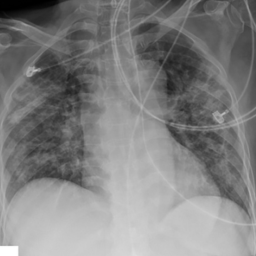

torch.Size([1, 256, 256]) tensor(1)


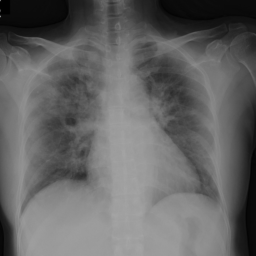

torch.Size([1, 256, 256]) tensor(1)


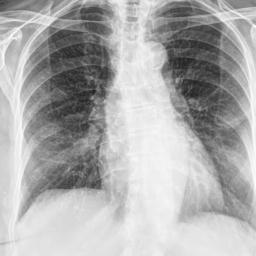

torch.Size([1, 256, 256]) tensor(1)


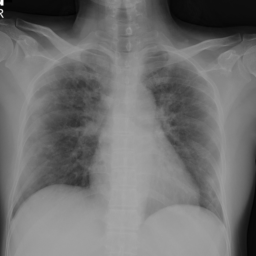

torch.Size([1, 256, 256]) tensor(1)


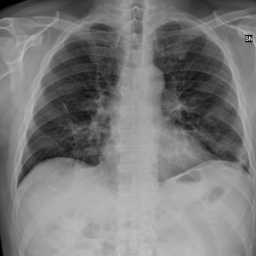

In [46]:
for i in range(5):
    img, label = testset.__getitem__(i)
    print(img.shape, label)
    display(transforms.ToPILImage()(img))

In [47]:
import model as mymodel
importlib.reload(mymodel)

<module 'model' from '/home/aka/Experiments/covid/covid-analysis/model.py'>

In [48]:
def initialize_using_pretrained(resnet):
    pretrained_resnet = torchvision.models.resnet18(pretrained=True)
    resnet.layer1.load_state_dict(pretrained_resnet.layer1.state_dict())
    resnet.layer2.load_state_dict(pretrained_resnet.layer2.state_dict())
    resnet.layer3.load_state_dict(pretrained_resnet.layer3.state_dict())
    resnet.layer4.load_state_dict(pretrained_resnet.layer4.state_dict())

In [49]:
resnet = mymodel.resnet18(num_classes=2)
initialize_using_pretrained(resnet)
resnet = resnet.to(device)

In [50]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=args.lr)
lmbda = lambda epoch: 1.0
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lmbda])

In [51]:
def train_epoch(epoch, model, optimizer, dataloader, writer):
    model.train()
    start_time = time.time()
    loss_logger = AverageMeter()
    total_step = len(dataloader.dataset)//args.batch_size
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        #pdb.set_trace()
        loss = F.cross_entropy(pred, labels)
        loss_logger.update(loss.item())
        
        if idx % args.log_step == 0:
            log_loss(epoch, idx, total_step, loss, start_time)
            start_time = time.time()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    accuracy = get_accuracy(model, dataloader)
    print('Train Acc:', accuracy)
    writer.add_scalar('Loss/train', loss_logger.avg, epoch)
    writer.add_scalar('Accuracy/train', accuracy, epoch)
    
def get_accuracy(model, dataloader):    
    model.eval()
    total = 0
    correct = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        #pdb.set_trace()
        pred_labels = torch.argmax(pred, 1)
        total += labels.size(0)
        correct += torch.sum(pred_labels == labels)
    return correct.cpu().numpy()/total

def test_epoch(epoch, model, dataloader, writer):
    model.eval()
    loss_logger = AverageMeter()
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        loss = F.cross_entropy(pred, labels)
        loss_logger.update(loss.item())
        
    accuracy = get_accuracy(model, dataloader)
    print('Test Acc:', accuracy)
    writer.add_scalar('Loss/test', loss_logger.avg, epoch)
    writer.add_scalar('Accuracy/test', accuracy, epoch)
        
def train(model, optimizer, scheduler, trainloader, testloader, writer):
    for epoch in range(args.num_epochs):
        train_epoch(epoch, model, optimizer, trainloader, writer)
        test_epoch(epoch, model, testloader, writer)
        scheduler.step()
    print('Saving the model')
    torch.save(model.state_dict(), net_path)

In [52]:
train(resnet, optimizer, scheduler, trainloader, testloader, writer)

Epoch [0/30], Step [0/13], Loss: 1.2371, time: 0.2238s
Train Acc: 0.5
Test Acc: 0.5
Epoch [1/30], Step [0/13], Loss: 0.0952, time: 0.3459s
Train Acc: 0.5
Test Acc: 0.5
Epoch [2/30], Step [0/13], Loss: 0.0080, time: 0.4562s
Train Acc: 0.5
Test Acc: 0.5
Epoch [3/30], Step [0/13], Loss: 0.0010, time: 0.3510s
Train Acc: 0.7727272727272727
Test Acc: 0.5357142857142857
Epoch [4/30], Step [0/13], Loss: 0.0245, time: 0.2461s
Train Acc: 0.8545454545454545
Test Acc: 0.6428571428571429
Epoch [5/30], Step [0/13], Loss: 0.6576, time: 0.3800s
Train Acc: 0.990909090909091
Test Acc: 0.7857142857142857
Epoch [6/30], Step [0/13], Loss: 1.2574, time: 0.5353s
Train Acc: 0.990909090909091
Test Acc: 0.75
Epoch [7/30], Step [0/13], Loss: 0.0167, time: 0.2628s
Train Acc: 1.0
Test Acc: 0.8928571428571429
Epoch [8/30], Step [0/13], Loss: 0.0175, time: 0.2838s
Train Acc: 1.0
Test Acc: 0.8571428571428571
Epoch [9/30], Step [0/13], Loss: 0.0486, time: 0.2543s
Train Acc: 1.0
Test Acc: 0.8571428571428571
Epoch [10/3

For setting of lr=1e-4, batch size=8, epochs=30:

Resnet18 is already overparameterized for this small dataset. So we stick to this model in the resnet family. For resnet18, best test accuracy obtained is ~93%. Note that test accuracy is ~96% at epoch 27.

## Insights
We can visualize on what the model focusses on from this data using CAM.

### CAM

In [55]:
import cam
importlib.reload(cam)

<module 'cam' from '/home/aka/Experiments/covid/covid-analysis/cam.py'>

COVID-19


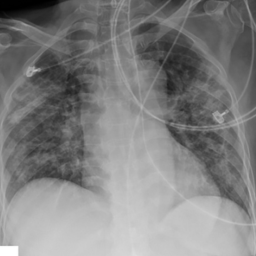

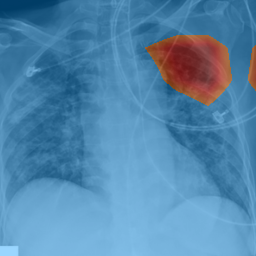

COVID-19


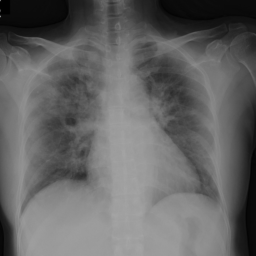

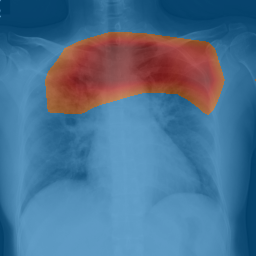

COVID-19


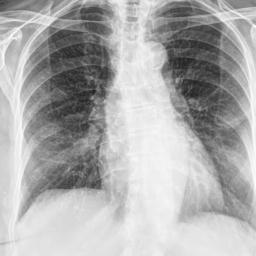

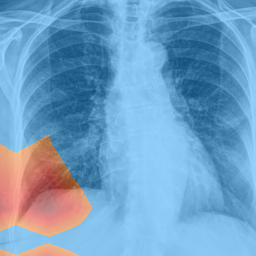

COVID-19


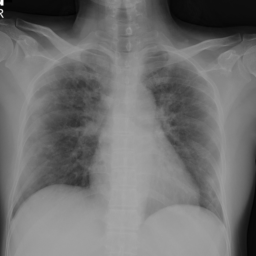

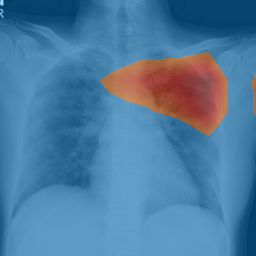

COVID-19


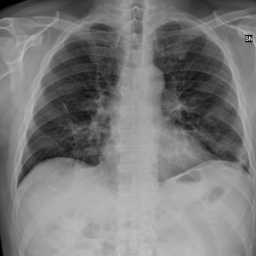

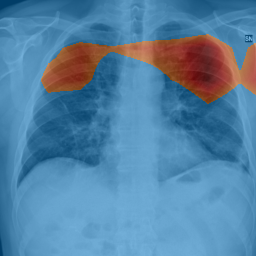

COVID-19


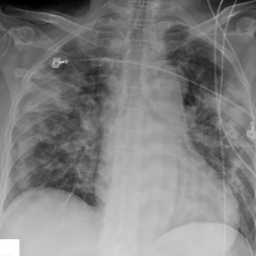

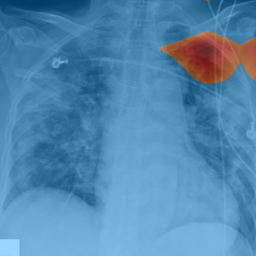

COVID-19


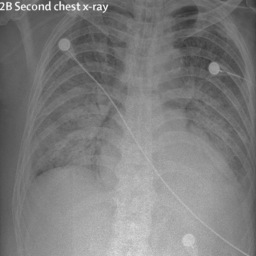

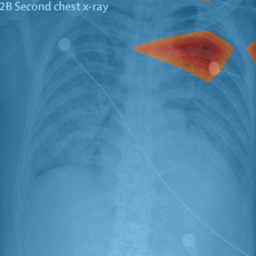

COVID-19


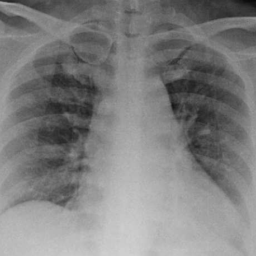

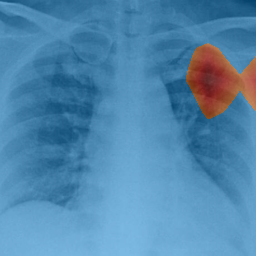

COVID-19


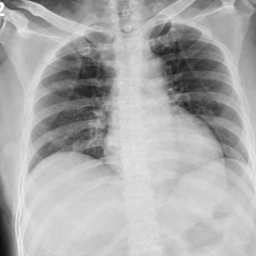

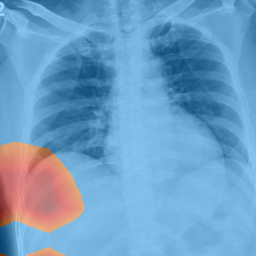

COVID-19


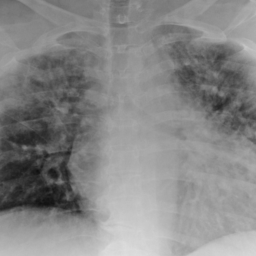

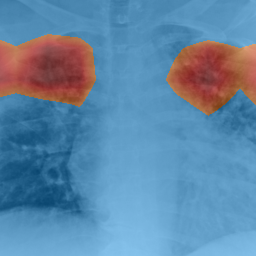

COVID-19


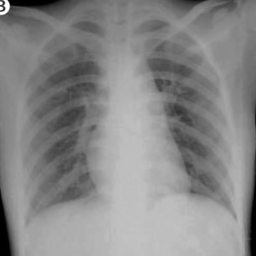

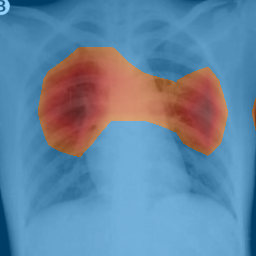

COVID-19


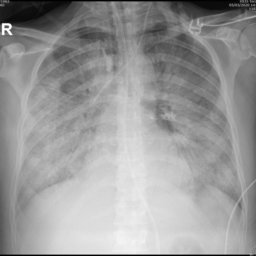

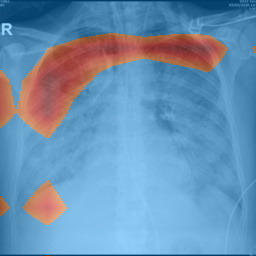

COVID-19


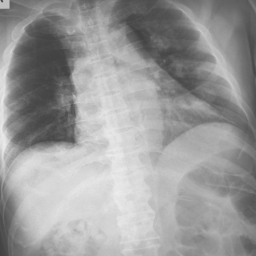

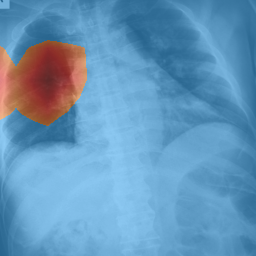

COVID-19


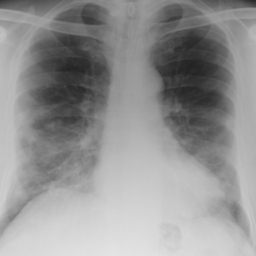

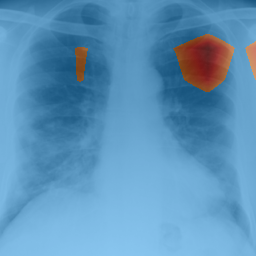

Normal


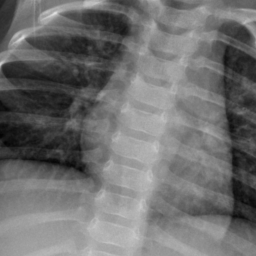

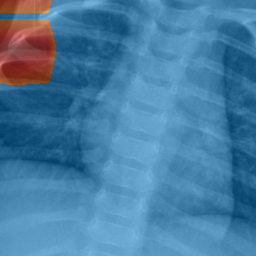

Normal


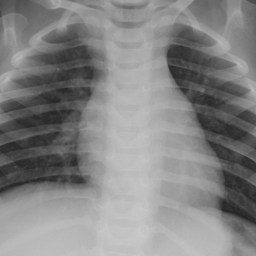

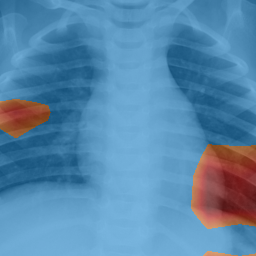

Normal


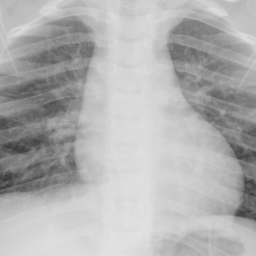

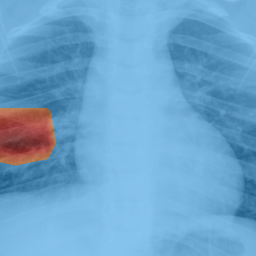

Normal


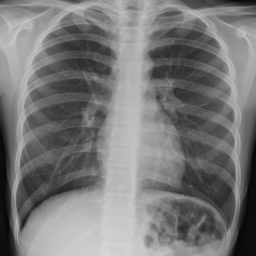

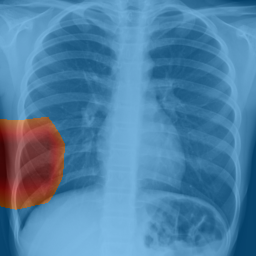

Normal


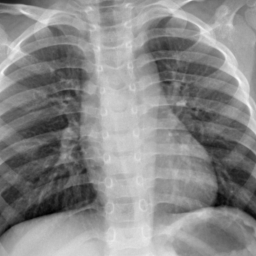

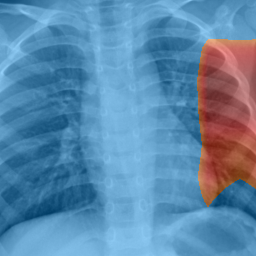

Normal


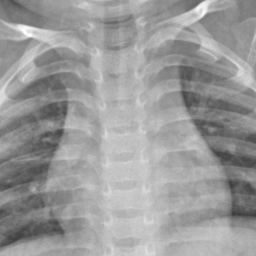

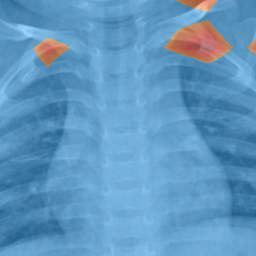

Normal


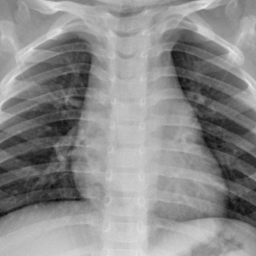

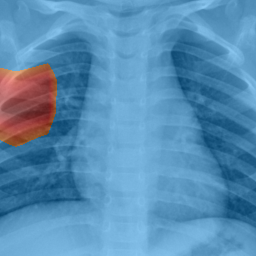

Normal


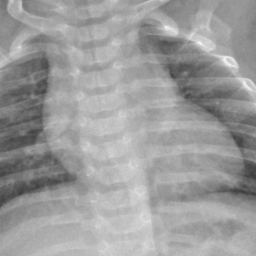

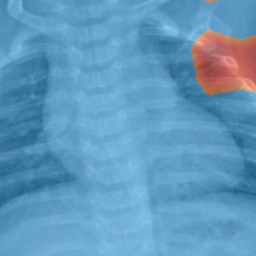

Normal


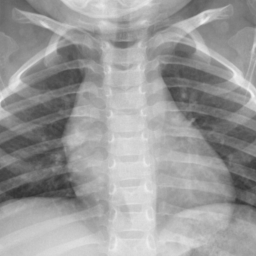

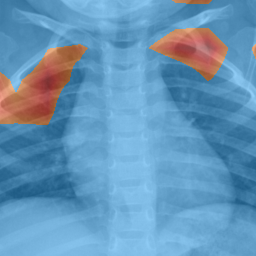

Normal


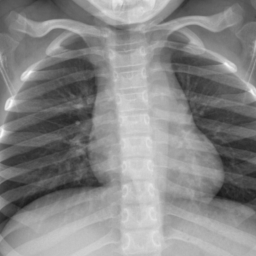

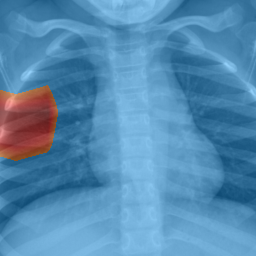

Normal


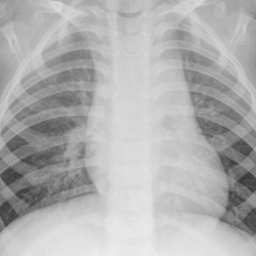

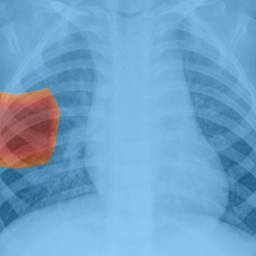

Normal


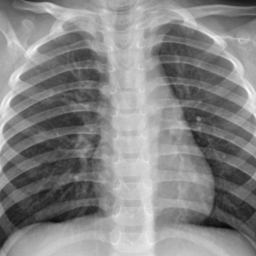

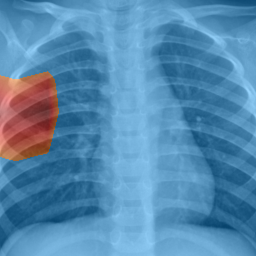

Normal


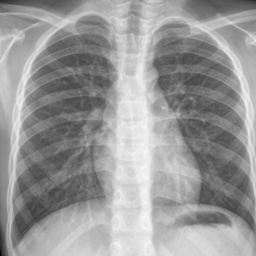

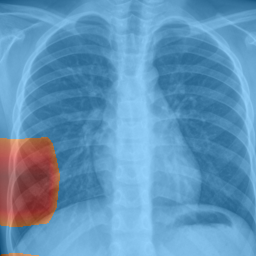

Normal


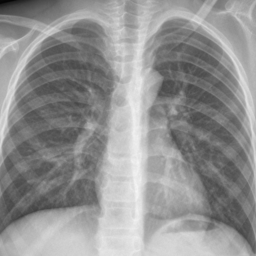

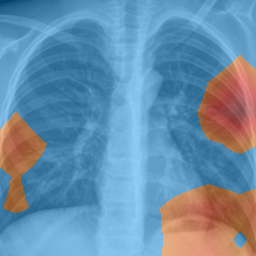

In [56]:
to_image = transforms.ToPILImage()
for i in range(len(testset)):
    img, label = testset.__getitem__(i)
    if label == 1:
        print('COVID-19')
    else:
        print('Normal')
    cam_img = cam.get_cam_images(resnet, 'layer4', img.to(device).unsqueeze(0), corona_idx=label)[0]
    display(to_image(img), cam_img)

The CAM regions obtained are quite wide and spread. The CAM is generated by up sampling 8x8 sized convolution features to 256x256. In the current CAM images the color regions are thresholded to generate contrast and easy visualization. 

It is not clear if the model has learned any meaningful feature from the exercise of predicting covid-19 from chest x rays when negative samples from healthy individuals are present. It suggests either CAM is not an appropriate technique for this kind of dataset or the dataset is too small for model to pick anything meaningful. Even I am uncertain about which regions are the clue to understand presence of covid-19 and a medical expert must be consulted. In followup I would use visualization from guided-grad-CAM; have chest-xray samples from other forms of pneumonia and respiratory illness so that the model is able to narrow down patterns which correspond to Covid-19.

### Grad-CAM
https://github.com/kazuto1011/grad-cam-pytorch#demo-1  (TODO)